This notebook is created on **22.July.2023** for the final project of **Natural Language Processing**.

Group Member: <br/>
 - Henri GARCIA-PELAYO;
 - Haozhe TANG;
 - Yuanyuan LIU.

# Libraries and Data Importing

In [2]:
! pip install datasets
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.9 MB/s eta 0:00:00


In [3]:
#Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re


# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, GlobalMaxPool1D, Flatten, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

# Sklearn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score


#NLP
import spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Data importing and converting

df = pd.read_csv('/content/drive/MyDrive/EPITA/Natural Language Processing/Final_project_dataset/NLP_exam_emotions_dataset/train.txt', sep=';', names=['Comment', 'Emotion'])
df.head()

,Comment,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [6]:
#Import testing dataset.
df_test = pd.read_csv('/content/drive/MyDrive/EPITA/Natural Language Processing/Final_project_dataset/NLP_exam_emotions_dataset/test.txt', sep=';', names=['Comment', 'Emotion'])
df_test.head()

,Comment,Emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


# 1. Data Exploration

In [7]:
# Check the shape of dataframe and the missing value existance.
df.info()

# This dataset has no missing value.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  16000 non-null  object
 1   Emotion  16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  2000 non-null   object
 1   Emotion  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


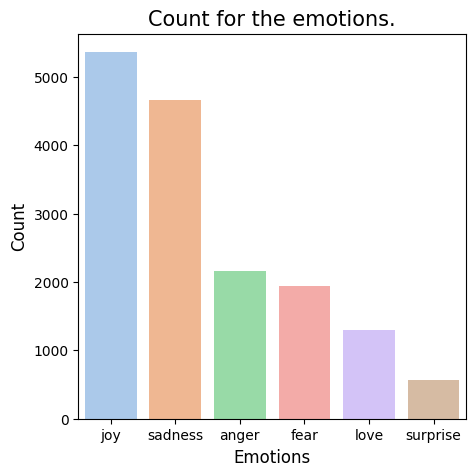

In [9]:
# Label discover for training dataset.
label_count = df['Emotion'].value_counts()
#Store the types.
emotion_types = list(label_count.index)
plt.figure(figsize=(5,5))
sns.barplot(x=label_count.index, y=label_count.values, palette='pastel')
plt.title('Count for the emotions.', fontsize=15)
plt.xlabel('Emotions', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

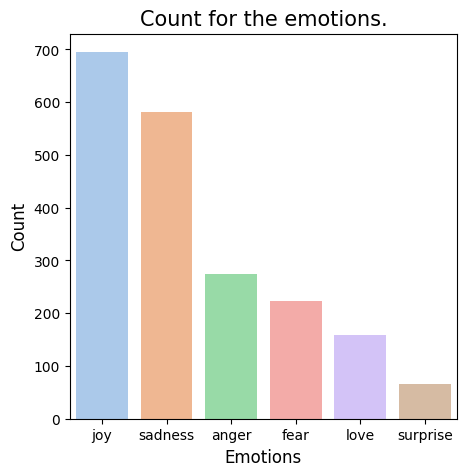

In [10]:
# Label discover for testing dataset.
label_count = df_test['Emotion'].value_counts()
plt.figure(figsize=(5,5))
sns.barplot(x=label_count.index, y=label_count.values, palette='pastel')
plt.title('Count for the emotions.', fontsize=15)
plt.xlabel('Emotions', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.show()

# 2. Data Splitting and Preprocessing

This dataset has been processed a lot:
 - It has no punctuations;
 - It has no capital letters;
 - It has no emojis etc.

So we can directly store them to the corpus

In [38]:
#Store all the comments and labels into a list.
corpus = df['Comment'].tolist()
labels = df['Emotion'].tolist()

X_test = df_test['Comment'].tolist()
y_test = df_test['Emotion'].tolist()

## 2.1 Preprocessing

In [12]:
#Import spacy language model
nlp = spacy.load('en_core_web_sm')

In [13]:
# Comments transformation
# Function to remove stopwords
def remove_stopwords(texts):
  return [[w for w in text.split(' ') if w not in stopwords.words('english')] for text in tqdm(texts)]

# Function to do lemmatising
def lemmatise(texts):
  lemmatised_texts = list()
  for comment in tqdm(texts):
    comment = " ".join(comment)
    doc = nlp(comment)

    lemmatised_texts.append(' '.join([token.lemma_ for token in doc]))

  return lemmatised_texts

#Main function
def transform(X):
  X = remove_stopwords(X)
  X = lemmatise(X)
  return X

In [14]:
#For training set
transformed_corpus = transform(corpus)


100%|██████████| 16000/16000 [02:29<00:00, 107.13it/s]


In [40]:
#For testing set
transformed_corpus_test = transform(X_test)

100%|██████████| 2000/2000 [00:18<00:00, 110.02it/s]


In [16]:
# Tokenisation for comments in training dataset
max_words = 8000

tokenizer = Tokenizer(
    num_words = max_words,
)
tokenizer.fit_on_texts(transformed_corpus)
transformed_corpus = tokenizer.texts_to_sequences(transformed_corpus)
transformed_corpus = pad_sequences(transformed_corpus, maxlen=300, padding='post')

In [41]:
# Tokenisation for comments in testing dataset
tokenizer.fit_on_texts(transformed_corpus_test)
transformed_corpus_test = tokenizer.texts_to_sequences(transformed_corpus_test)
transformed_corpus_test = pad_sequences(transformed_corpus_test, maxlen=300, padding='post')

In [18]:
# Tokenisation for labels in training dataset
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

labels = np.array(label_tokenizer.texts_to_sequences(labels))

In [42]:
# Tokenisation for labels in testing dataset
label_tokenizer.fit_on_texts(y_test)

y_test = np.array(label_tokenizer.texts_to_sequences(y_test))

In [20]:
#Get the size of the vocabulary
vocab_size=len(tokenizer.word_index)+1

In [43]:
#Do the one-hot encoding for labels of training and testing dataset.
onc = OneHotEncoder()
labels = onc.fit_transform(labels)
labels = labels.toarray()

y_test = onc.fit_transform(y_test)
y_test = y_test.toarray()

## 2.2 Split dataset

In this project, we plan to split the dataset into:
 - 90% for training set;
 - 10% for validation set;

And testing dataset is a separate file.

In [53]:
# Split into train and the val datasets
X_train, X_val, y_train, y_val = train_test_split(transformed_corpus, labels, stratify=labels, test_size=0.1, random_state=42)
X_test, y_test = transformed_corpus_test, y_test

# 3. Classification Models

In [23]:
#Build a function to plot learning curves
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=["loss", "accuracy", "val_loss", "val_accuracy"]
    hist_df.index = np.arange(1, len(hist_df)+1)

    fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
    axs[0].plot(hist_df.val_accuracy, lw=3, label='Validation Accuracy')
    axs[0].plot(hist_df.accuracy, lw=3, label='Training Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].grid()
    axs[0].legend(loc=0)
    axs[1].plot(hist_df.val_loss, lw=3, label='Validation Loss')
    axs[1].plot(hist_df.loss, lw=3, label='Training Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].grid()
    axs[1].legend(loc=0)

    plt.show()

## 3.1 Fully Connected Neural Network

In [28]:
CNN_model = Sequential()
CNN_model.add(Embedding(input_dim=vocab_size, output_dim = 64, input_length=300))
CNN_model.add(Flatten())
CNN_model.add(Dense(256, activation='relu'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Dense(128, activation='relu'))
CNN_model.add(Dense(64, activation='relu'))
CNN_model.add(Dense(32, activation='relu'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Dense(6, activation='softmax'))


In [29]:
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 64)           827584    
                                                                 
 flatten (Flatten)           (None, 19200)             0         
                                                                 
 dense_5 (Dense)             (None, 256)               4915456   
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)               

In [30]:
#Parameters
loss='categorical_crossentropy'
optimizer= Adam(learning_rate=1e-4)
metrics=['accuracy']


CNN_model.compile(loss=loss, optimizer=optimizer, metrics=metrics)


In [31]:
CNN_history = CNN_model.fit(x=X_train,
                    y=y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/10
450/450 [==============================] - 37s 67ms/step - loss: 1.6167 - accuracy: 0.3223 - val_loss: 1.5781 - val_accuracy: 0.3350
Epoch 2/10
450/450 [==============================] - 7s 15ms/step - loss: 1.5956 - accuracy: 0.3247 - val_loss: 1.5743 - val_accuracy: 0.3350
Epoch 3/10
450/450 [==============================] - 4s 8ms/step - loss: 1.5866 - accuracy: 0.3221 - val_loss: 1.5611 - val_accuracy: 0.3350
Epoch 4/10
450/450 [==============================] - 4s 8ms/step - loss: 1.4838 - accuracy: 0.3340 - val_loss: 1.3254 - val_accuracy: 0.3537
Epoch 5/10
450/450 [==============================] - 4s 8ms/step - loss: 1.1911 - accuracy: 0.4158 - val_loss: 1.1479 - val_accuracy: 0.4256
Epoch 6/10
450/450 [==============================] - 5s 10ms/step - loss: 1.0964 - accuracy: 0.4362 - val_loss: 1.1524 - val_accuracy: 0.4375
Epoch 7/10
450/450 [==============================] - 4s 8ms/step - loss: 1.0539 - accuracy: 0.4503 - val_loss: 1.1274 - val_accuracy: 0.4306
Ep

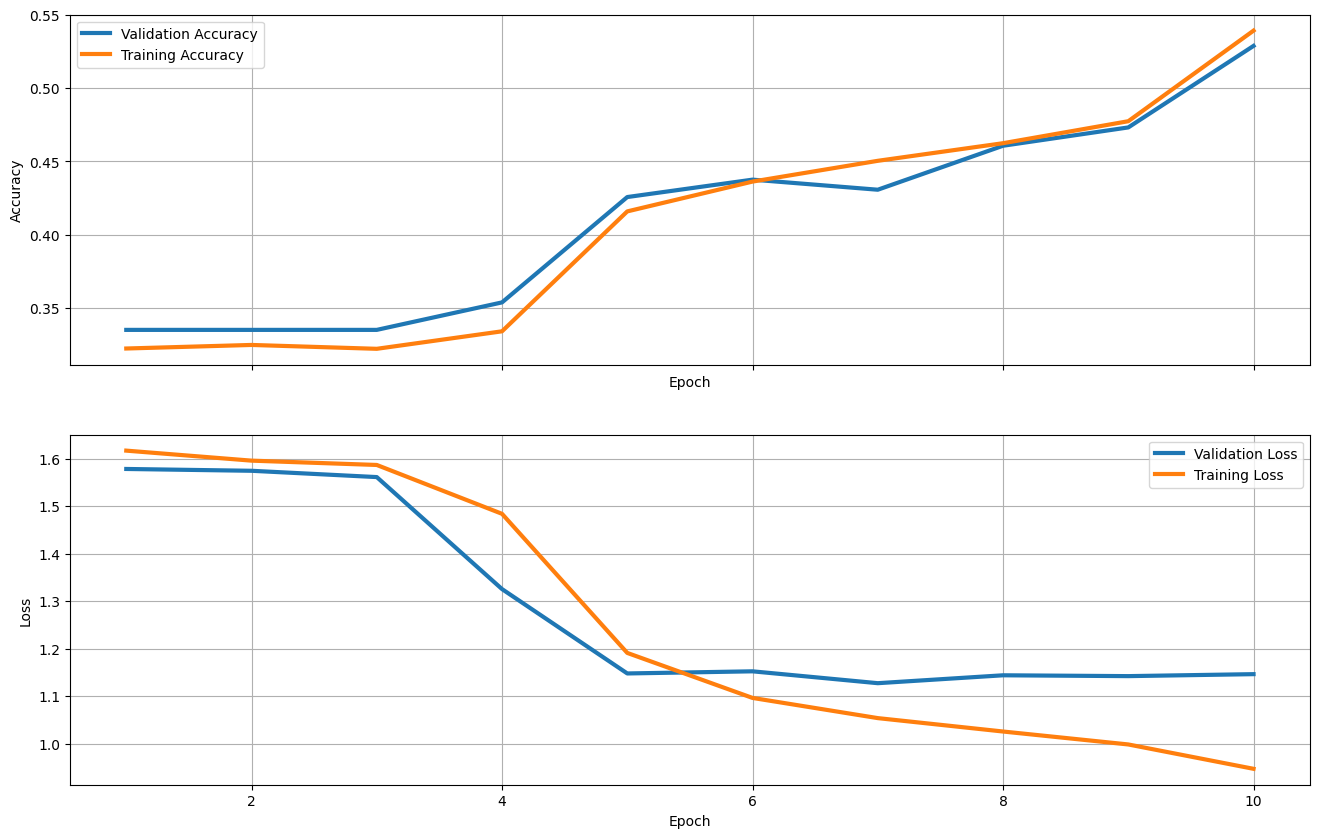

In [32]:
plot_results(CNN_history)

In [33]:
#Evalute the model and prediction
CNN_model.evaluate(X_test, y_test)
y_pred1 = CNN_model.predict(X_test)
predictied_label_CNN = np.argmax(y_pred1, axis=1)

63/63 [==============================] - 0s 3ms/step


In [45]:
y_test = np.argmax(y_test, axis=1)

In [47]:
#Report
report1 = classification_report(y_test, predictied_label_CNN, target_names=emotion_types)
print(report1)

              precision    recall  f1-score   support

         joy       0.40      0.33      0.36       695
     sadness       0.31      0.46      0.37       581
       anger       0.17      0.18      0.18       275
        fear       0.22      0.13      0.17       224
        love       0.07      0.06      0.07       159
    surprise       0.00      0.00      0.00        66

    accuracy                           0.29      2000
   macro avg       0.20      0.19      0.19      2000
weighted avg       0.28      0.29      0.28      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 3.2 Recurrent Neural Network (RNN) LSTM based

In [24]:
from keras.api._v2.keras import activations
# Model building
LSTM_model = Sequential()
LSTM_model.add(Embedding(input_dim=max_words, output_dim = 64, input_length=300))
# LSTM_model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3, activation='tanh'))
LSTM_model.add(Bidirectional(LSTM(32, dropout=0.3, recurrent_dropout=0.3, activation='tanh')))
LSTM_model.add(Dense(128, activation='relu'))
LSTM_model.add(Dropout(.2))
LSTM_model.add(Dense(64, activation='relu'))
LSTM_model.add(Dropout(.2))
# LSTM_model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3, activation='tanh'))|
LSTM_model.add(Dense(32, activation='relu'))
LSTM_model.add(Dropout(.2))
LSTM_model.add(Dense(16, activation='relu'))
LSTM_model.add(Dropout(.2))
LSTM_model.add(Dense(6, activation='softmax'))


In [25]:
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 64)           512000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               24832     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

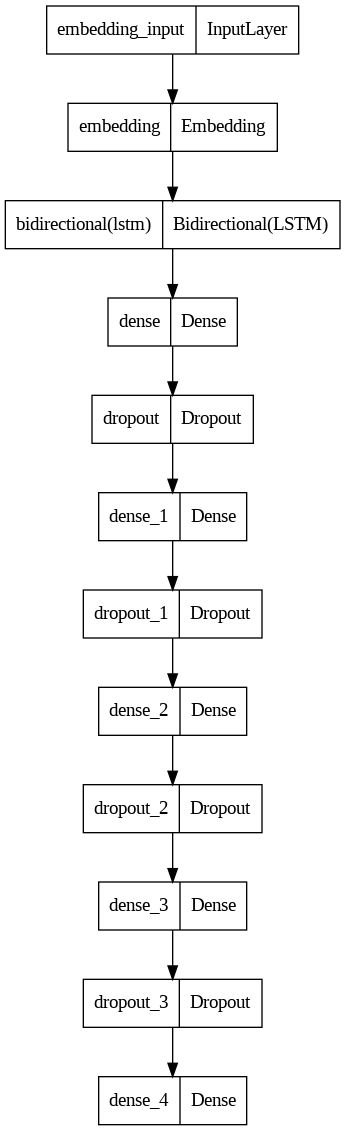

In [26]:
plot_model(LSTM_model)

In [48]:
#Compile and fit on training and validation set.
#Parameters

LSTM_model.compile(
    loss=loss,
    optimizer=Adam(),
    metrics=metrics
)


epochs = 10
batch_size=64

LSTM_history = LSTM_model.fit(x=X_train,
                              y=y_train,
                              validation_data=(X_val, y_val),
                              epochs=epochs,
                              batch_size=batch_size)

Epoch 1/10
225/225 [==============================] - 325s 1s/step - loss: 1.5300 - accuracy: 0.3276 - val_loss: 1.2344 - val_accuracy: 0.4181
Epoch 2/10
225/225 [==============================] - 292s 1s/step - loss: 1.1779 - accuracy: 0.4274 - val_loss: 1.1240 - val_accuracy: 0.4400
Epoch 3/10
225/225 [==============================] - 295s 1s/step - loss: 1.0465 - accuracy: 0.4624 - val_loss: 1.0745 - val_accuracy: 0.4819
Epoch 4/10
225/225 [==============================] - 292s 1s/step - loss: 0.9726 - accuracy: 0.4967 - val_loss: 1.0589 - val_accuracy: 0.4981
Epoch 5/10
225/225 [==============================] - 291s 1s/step - loss: 0.9051 - accuracy: 0.5417 - val_loss: 1.0721 - val_accuracy: 0.5387
Epoch 6/10
225/225 [==============================] - 284s 1s/step - loss: 0.7992 - accuracy: 0.6484 - val_loss: 1.0301 - val_accuracy: 0.6762
Epoch 7/10
225/225 [==============================] - 281s 1s/step - loss: 0.5980 - accuracy: 0.7967 - val_loss: 0.7974 - val_accuracy: 0.8219

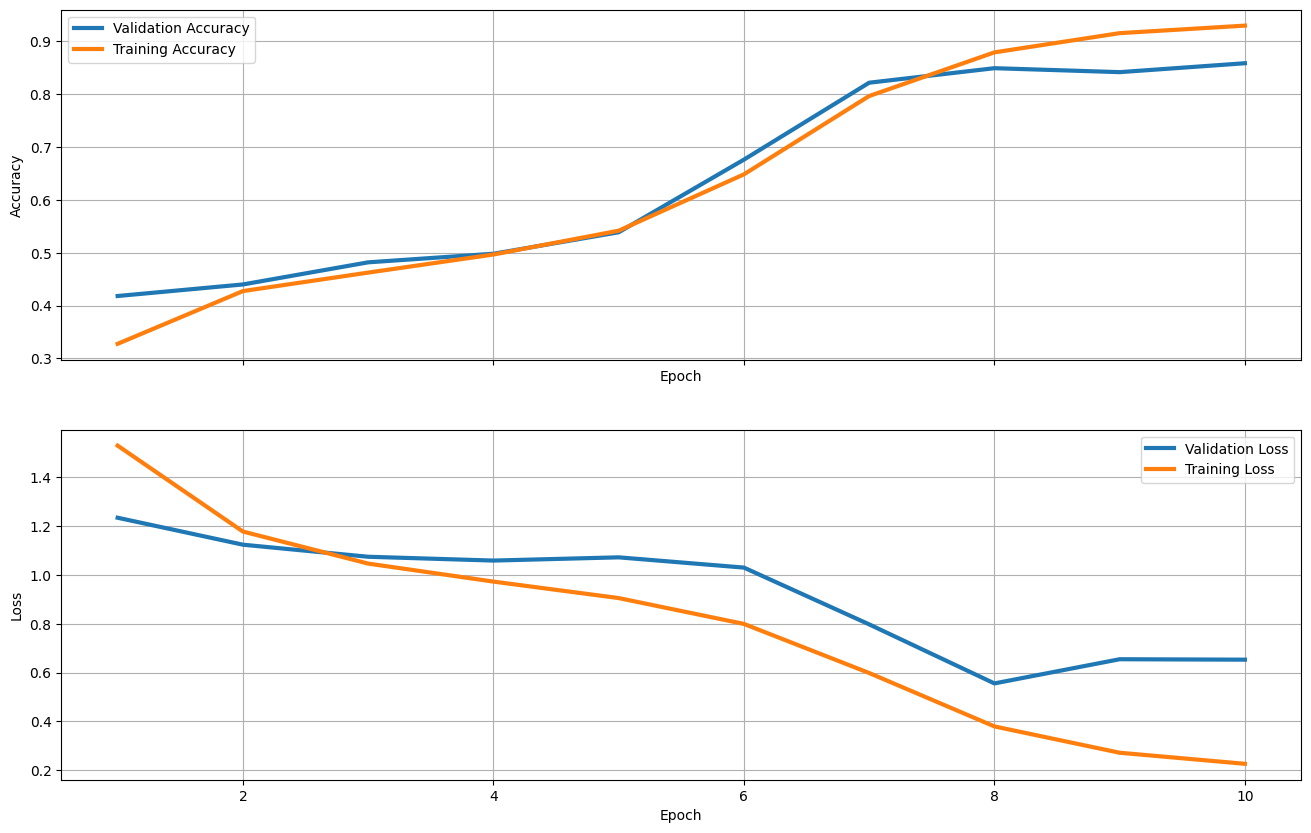

In [49]:
plot_results(LSTM_history)

In [62]:
#Evalute the model and prediction
# LSTM_model.evaluate(X_test, y_test)
y_pred2 = LSTM_model.predict(X_test)
predictied_label_LSTM = np.argmax(y_pred2, axis=1)

63/63 [==============================] - 18s 283ms/step


In [63]:
#Report
report2 = classification_report(y_test, predictied_label_LSTM, target_names=emotion_types)
print(report2)

              precision    recall  f1-score   support

         joy       0.38      0.35      0.36       695
     sadness       0.29      0.32      0.30       581
       anger       0.14      0.11      0.12       275
        fear       0.08      0.05      0.06       224
        love       0.10      0.15      0.12       159
    surprise       0.01      0.02      0.01        66

    accuracy                           0.25      2000
   macro avg       0.17      0.17      0.16      2000
weighted avg       0.25      0.25      0.25      2000



## 3.3 Fine-tuned transformer architechture

In [ ]:
! pip install -U accelerate
! pip install -U transformers
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.5 MB/s eta 0:00:00


In [ ]:
# Load a pretrained model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/Final/NLP_exam_emotions_dataset/train.txt', delimiter=';', header=None, names=['text', 'label'])

# Convert string labels to integers
label_encoder = LabelEncoder()
label_encoder.fit(df['label'])
df['label'] = label_encoder.transform(df['label'])

# Split the dataset into training and validation sets
train_df, valid_df = train_test_split(df, test_size=0.2)

# Convert a dataframe into a dataset
def df_to_dataset(df):
    dataset = Dataset.from_pandas(df)
    dataset = dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length'), batched=True)
    dataset = dataset.map(lambda e: {'labels': e['label']})
    return dataset

# Convert the dataframes into datasets
train_dataset = df_to_dataset(train_df)
valid_dataset = df_to_dataset(valid_df)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12800 [00:00<?, ? examples/s]

Map:   0%|          | 0/12800 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

In [ ]:
train_df['label']

676      2
12113    4
7077     3
13005    4
12123    0
        ..
13418    1
5390     3
860      4
15795    4
7270     0
Name: label, Length: 12800, dtype: int64

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy': accuracy_score(labels, predictions)}

In [ ]:
# # Freeze all the parameters
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze the classifier layer for fine-tuning
# for param in model.classifier.parameters():
#     param.requires_grad = True

# Fine-tune the model
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01, # Regularization parameter to prevent overfitting
    logging_dir='./logs',
    evaluation_strategy='epoch',  # Evaluate the model at the end of each epoch
    save_strategy='epoch',  # Save the model at the end of each epoch
    load_best_model_at_end=True,  # Load the best model when finished training (even if the number of epochs is not reached).
    metric_for_best_model='accuracy',  # Use accuracy to determine the best model.
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,  # Compute accuracy during training for early stopping
)

trainer.train()

# Save the fine-tuned model
model.save_pretrained('./my_finetuned_model')

Epoch,Training Loss,Validation Loss,Accuracy
1,1.658500,1.564317,0.351562
2,1.571500,1.546130,0.377812
3,1.559000,1.543458,0.370312


In [ ]:
model_test_name = "/content/my_finetuned_model"
model_test = AutoModelForSequenceClassification.from_pretrained(model_test_name, num_labels=6)

In [ ]:
import pandas as pd
from datasets import Dataset

df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/Final/NLP_exam_emotions_dataset/test.txt', sep=';', names=['text', 'label'])

def df_to_test_dataset(df):
    dataset = Dataset.from_pandas(df[['text']])  # Only include the 'text' column
    dataset = dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length'), batched=True)
    return dataset

test_dataset = df_to_test_dataset(df_test)

trainer = Trainer(
    model=model_test,
    args=training_args,
)

predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(-1)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
true_labels_encoded = label_encoder.transform(df_test['label'].values)
accuracy = accuracy_score(true_labels_encoded, predicted_labels)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.393


# 4. Comparisons and new application

## 4.1 Model Comparison

In [64]:
print(f'The classification report of model 1: FCNN model:\n', report1)
print('\n\n')
print(f'The classification report of model 2: LSTM model:\n', report2)
print('\n\n')
print(f'The accuracy of model 3: 0.393')

The classification report of model 1: FCNN model:
               precision    recall  f1-score   support

         joy       0.40      0.33      0.36       695
     sadness       0.31      0.46      0.37       581
       anger       0.17      0.18      0.18       275
        fear       0.22      0.13      0.17       224
        love       0.07      0.06      0.07       159
    surprise       0.00      0.00      0.00        66

    accuracy                           0.29      2000
   macro avg       0.20      0.19      0.19      2000
weighted avg       0.28      0.29      0.28      2000




The classification report of model 2: LSTM model:
               precision    recall  f1-score   support

         joy       0.38      0.35      0.36       695
     sadness       0.29      0.32      0.30       581
       anger       0.14      0.11      0.12       275
        fear       0.08      0.05      0.06       224
        love       0.10      0.15      0.12       159
    surprise       0.01    

## 4.2 New application with model 3

We can clearly see that the **model 3** performs the best among the three models. <br/><br/>So we plan to use the pre-training model to apply on the **"real time" dataset.**

In [ ]:
df_real = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/Final/NLP_exam_real_case_dataset/train.csv').iloc[:, 1:]
# df_real = pd.read_csv('/content/drive/MyDrive/EPITA/Natural Language Processing/Final_project_dataset/NLP_exam_real_case_dataset/complete.csv').iloc[:, 1:]
df_real.head()

,article_title,is_ecology
0,Stations essence à Rochefort-en-Terre : les me...,0
1,"À Brest, le chantier de La Boussole se fait at...",0
2,Météorite en Normandie : à la recherche de pré...,0
3,Résultats trimestriels mitigés pour les géants...,0
4,Opinion | Sobriété énergétique : les solutions...,1


In [ ]:
#Some easy explorations.
df_real.info()
#No missing data.

#Counts for label values
df_real['is_ecology'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215 entries, 0 to 2214
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   article_title  2215 non-null   object
 1   is_ecology     2215 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 34.7+ KB


0    2163
1      52
Name: is_ecology, dtype: int64

In [ ]:
corpus_real = df_real['article_title'].tolist()
labels_real = df_real['is_ecology'].tolist()

In [ ]:
# Comments transformation
# Function to turn all the letters into lowercase
def lowercase(texts):
  return [text.lower() for text in texts]

# Function to remove punctuations
def remove_punctuation(texts):
  pattern = re.compile('[^a-z]')
  return [re.sub(pattern, ' ', text) for text in texts]

# Function to remove double spaces
def remove_double_space(texts):
  pattern = re.compile(' +')
  return [re.sub(pattern, ' ', text) for text in texts]

# Function to remove stopwords
def remove_stopwords(texts):
  return [[w for w in text.split(' ') if w not in stopwords.words('french')] for text in tqdm(texts)]

# Function to do lemmatising
def lemmatise(texts):
  lemmatised_texts = list()
  for comment in tqdm(texts):
    comment = " ".join(comment)
    doc = nlp(comment)

    lemmatised_texts.append(' '.join([token.lemma_ for token in doc]))

  return lemmatised_texts

#Main function
def transform_real(X):
  X = lowercase(X)
  X = remove_punctuation(X)
  X = remove_double_space(X)
  X = remove_stopwords(X)
  X = lemmatise(X)
  return X

In [ ]:
#For the corpus ()
transformed_corpus_real = transform_real(corpus_real)

100%|██████████| 2215/2215 [00:22<00:00, 98.96it/s] 


In [ ]:
#Tokenisation for comments
max_words = 5000

tokenizer = Tokenizer(
    num_words = max_words,
)
tokenizer.fit_on_texts(transformed_corpus)
transformed_corpus_real = tokenizer.texts_to_sequences(transformed_corpus_real)
transformed_corpus_real = pad_sequences(transformed_corpus_real, maxlen=200, padding='post')


AttributeError: ignored

In [ ]:
# Load a pretrained model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# # Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/Final/NLP_exam_real_case_dataset/train.csv')
df = df.rename(columns={'article_title': 'text', 'is_ecology': 'label'})
df = df.drop(columns=['Unnamed: 0'])

# Split the dataset into training and validation sets
train_df, valid_df = train_test_split(df, test_size=0.2)

# Convert a dataframe into a dataset
def df_to_dataset(df):
    dataset = Dataset.from_pandas(df)
    dataset = dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length'), batched=True)
    dataset = dataset.map(lambda e: {'labels': e['label']})
    return dataset

# Convert the dataframes into datasets
train_dataset = df_to_dataset(train_df)
valid_dataset = df_to_dataset(valid_df)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1772 [00:00<?, ? examples/s]

Map:   0%|          | 0/1772 [00:00<?, ? examples/s]

Map:   0%|          | 0/443 [00:00<?, ? examples/s]

Map:   0%|          | 0/443 [00:00<?, ? examples/s]

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy': accuracy_score(labels, predictions)}

In [ ]:
# # Freeze all the parameters
# for param in model.parameters():
#     param.requires_grad = False

# # Unfreeze the classifier layer for fine-tuning
# for param in model.classifier.parameters():
#     param.requires_grad = True

# Fine-tune the model
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01, # Regularization parameter to prevent overfitting
    logging_dir='./logs',
    evaluation_strategy='epoch',  # Evaluate the model at the end of each epoch
    save_strategy='epoch',  # Save the model at the end of each epoch
    load_best_model_at_end=True,  # Load the best model when finished training (even if the number of epochs is not reached).
    metric_for_best_model='accuracy',  # Use accuracy to determine the best model.
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,  # Compute accuracy during training for early stopping
)

trainer.train()

# Save the fine-tuned model
model.save_pretrained('./my_finetuned_real_model')

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.129369,0.972912
2,No log,0.134162,0.972912
3,No log,0.110353,0.972912


In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/Final/NLP_exam_real_case_dataset/test.csv')
df_test = df_test.rename(columns={'article_title': 'text', 'is_ecology': 'label'})
df_test = df_test.drop(columns=['Unnamed: 0'])

def df_to_test_dataset(df):
    dataset = Dataset.from_pandas(df[['text']])  # Only include the 'text' column
    dataset = dataset.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length'), batched=True)
    return dataset

test_dataset = df_to_test_dataset(df_test)

predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(-1)

Map:   0%|          | 0/294 [00:00<?, ? examples/s]

In [ ]:
accuracy = accuracy_score(df_test['label'], predicted_labels)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.8197278911564626
